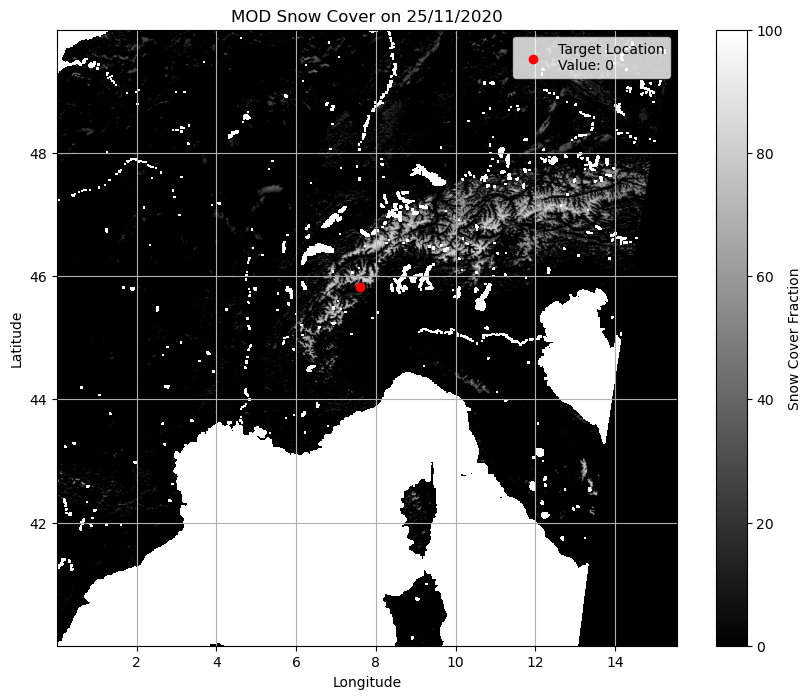

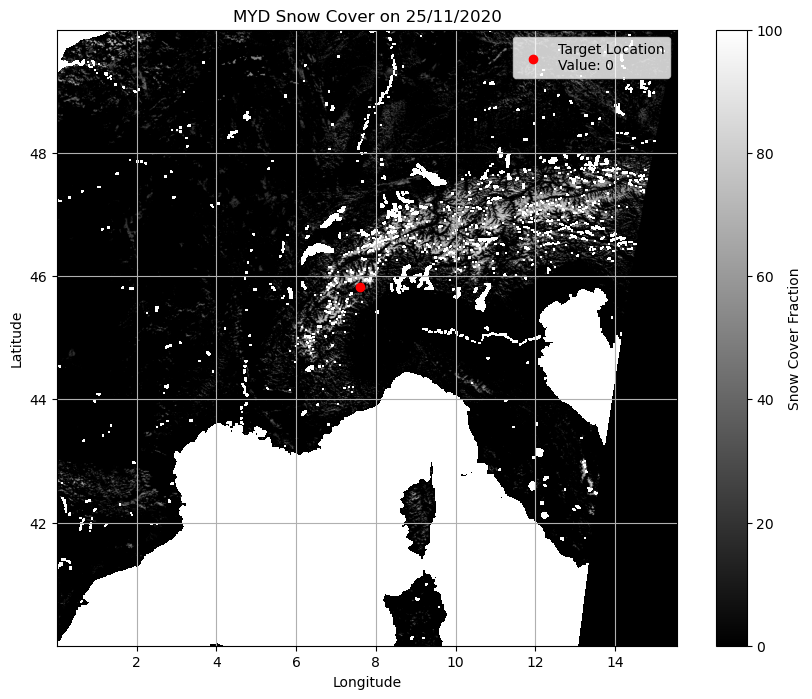

In [45]:
import numpy as np
import pandas as pd
from pyhdf.SD import SD, SDC
import pyproj
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds

df = pd.read_pickle('five_sites_0-05_0-005box_n_photons.pkl')
df = df[df['camera'] == 'torgnon'].reset_index()

def extract_nums(text, point='ul'):
    if point == 'ul':
        pattern = r'UpperLeftPointMtrs=\((.*?)\)'
    else:
        pattern = r'LowerRightMtrs=\((.*?)\)'
    
    match = re.search(pattern, text)
    if match:
        result = match.group(1)
        return parse_coordinates(result)
    else:
        return None, None

def parse_coordinates(coordinate_str):
    try:
        x_str, y_str = coordinate_str.split(',')
        x = float(x_str)
        y = float(y_str)
        return x, y
    except ValueError:
        return None, None

def get_day_of_year(date_str):
    date_obj = pd.to_datetime(date_str, format='%d/%m/%Y')
    return date_obj.strftime('%j')

def find_matching_hdf(year, day_of_year, start, hdf_dir):
    prefix = f'{start}10A1F.A{year}{day_of_year}'
    suffix = '.hdf'
    files = os.listdir(hdf_dir)
    for file in files:
        if file.startswith(prefix) and file.endswith(suffix):
            return file
    return None

def hdf_to_latlon(hdf_path):
    hdf = SD(hdf_path, SDC.READ)
    dataset = hdf.select('CGF_NDSI_Snow_Cover')
    data = dataset[:]
    
    ulx, uly = extract_nums(hdf.attributes()['StructMetadata.0'], point='ul')
    lrx, lry = extract_nums(hdf.attributes()['StructMetadata.0'], point='lr')
    nx, ny = data.shape
    
    xres = (lrx - ulx) / float(nx)
    yres = (uly - lry) / float(ny)
    
    x = np.linspace(ulx + xres / 2, lrx - xres / 2, nx)
    y = np.linspace(uly - yres / 2, lry + yres / 2, ny)
    xv, yv = np.meshgrid(x, y)
    
    sin_proj = pyproj.Proj(proj='sinu', R=6371007.181, no_defs=True)
    wgs84_proj = pyproj.Proj(proj='latlong', datum='WGS84')
    
    lon, lat = pyproj.transform(sin_proj, wgs84_proj, xv, yv)
    
    hdf.end()
    
    return lat, lon, data, ulx, uly, lrx, lry

df['MOD10A1F'] = None
df['MYD10A1F'] = None

for index, row in df.iterrows():
    if index == 330:
        for start in ['MOD', 'MYD']:
            place = row['camera']
            target_lat = row['latitude']
            target_lon = row['longitude']
            
            hdf_dir = f'../data_store/data/{start}10A1F_{place}/'
            
            date_str = row['date']
            day_of_year = get_day_of_year(date_str)
            year = date_str[-4:]
            
            hdf_filename = find_matching_hdf(year, day_of_year, start, hdf_dir)
            
            if hdf_filename is None:
                print(f"HDF file for '{date_str}' not found.")
                continue
            
            hdf_path = os.path.join(hdf_dir, hdf_filename)
            
            latitude, longitude, snow_cover_data, ulx, uly, lrx, lry = hdf_to_latlon(hdf_path)

            # Now we reproject the data
            src_transform = from_bounds(ulx, lry, lrx, uly, snow_cover_data.shape[1], snow_cover_data.shape[0])
            src_crs = rasterio.crs.CRS.from_proj4('+proj=sinu +R=6371007.181 +nadgrids=@null +wktext')

            dst_transform, width, height = calculate_default_transform(
                src_crs, 'EPSG:4326', snow_cover_data.shape[1], snow_cover_data.shape[0], 
                left=ulx, bottom=lry, right=lrx, top=uly
            )

            reprojected_data = np.empty((height, width), np.float32)

            reproject(
                source=snow_cover_data,
                destination=reprojected_data,
                src_transform=src_transform,
                src_crs=src_crs,  # Sinusoidal projection
                dst_transform=dst_transform,
                dst_crs='EPSG:4326',
                resampling=Resampling.nearest
            )
            
            reprojected_data[reprojected_data > 100] = np.nan

            # Display the snow cover data, limiting the scale to 0-100
            plt.figure(figsize=(10, 8))
            img = plt.imshow(reprojected_data, cmap='gray', extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()], vmin=0, vmax=100, aspect='auto')
            plt.scatter(target_lon, target_lat, color='red', label=f"Target Location\nValue: {value}")
            plt.colorbar(img, label='Snow Cover Fraction')
            plt.title(f'{start} Snow Cover on {date_str}')
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.legend()
            plt.grid(True)
            plt.show()
    
            df.at[index, f'{start}10A1F'] = value
    
        break  # Remove this break if you want to process all rows in the dataframe

# You can save the dataframe if needed
# df.to_pickle('five_sites_0-05_0-005box_n_photons_snowreffed.pkl')
